# Resources
- [GnuCash Python Account Analysis Example](https://github.com/Gnucash/gnucash/blob/stable/bindings/python/example_scripts/account_analysis.py#L77)
- [Stacked Bar Chart MPL](https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html)

In [1]:
import hist

In [3]:
from gnucash import Session, GncNumeric, Split, SessionOpenMode, Transaction, Account

In [4]:
import numpy as np
import datetime

In [5]:
num_groups = 6
num_weeks_per_group = 2
    
def expense_category(a: Account):
    if a.is_root() or a.get_parent().is_root():
        return None
    if a.get_parent().GetName() == 'Expenses':
        return a.GetName()
    if a.get_parent().get_parent().GetName() == 'Expenses':
        return a.get_parent().GetName()
    return None

def gnc_numeric_to_python_float(numeric: GncNumeric):
    return numeric.num() / numeric.denom()

In [6]:
time_diff = datetime.timedelta(weeks=num_weeks_per_group).total_seconds()
today = datetime.datetime.now()

tom_expenses = hist.Hist(
    hist.axis.Regular(
        bins=num_groups,start=-num_groups*time_diff, stop=0,
        underflow=False, # ignore expenses earlier than start date
        overflow=True, # overflow is "current/future" expenses
        name='time'
    ),
    hist.axis.StrCategory([],growth=True,name='category'),
    storage = hist.storage.Weight()
)

with Session('/home/tom/Documents/Personal/FinancialRecords/FinancialRecords.gnucash', SessionOpenMode.SESSION_NORMAL_OPEN) as session:
    root = session.book.get_root_account()
    accounts = [root.lookup_by_name(name) for name in ['Tom Checking','Chase Freedom']]
    expenses = {}
    for account in accounts:
        for split in account.GetSplitList():
            transaction = split.GetParent()
            for subsplit in transaction.GetSplitList():
                if subsplit.GetAccount().GetName() == account.GetName():
                    continue
                ecat = expense_category(subsplit.GetAccount())
                if ecat is None:
                    #print(subsplit.GetAmount(), subsplit.GetAccount().GetName())
                    continue
                amount = gnc_numeric_to_python_float(subsplit.GetAmount())
                tom_expenses.fill(
                    time = (transaction.GetDate()-today).total_seconds(),
                    category = ecat,
                    weight = amount
                )

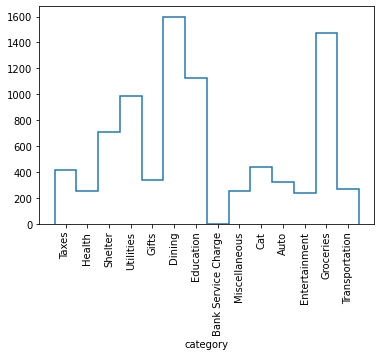

In [7]:
import matplotlib.pyplot as plt
tom_expenses[sum,...].plot(yerr=False)
plt.xticks(rotation=90)
plt.show()

In [15]:
times = tom_expenses.axes[0].centers
xticks_kw = dict(
    ticks = times,
    labels = [
        str((today+datetime.timedelta(seconds=s)).date())
        for s in tom_expenses.axes[0].centers
    ],
    rotation = 90 
)

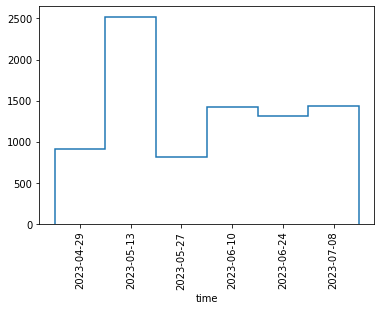

In [17]:
tom_expenses[...,sum].plot(yerr=False)
plt.xticks(**xticks_kw)
plt.show()

In [18]:
by_cat = tom_expenses.stack('category')

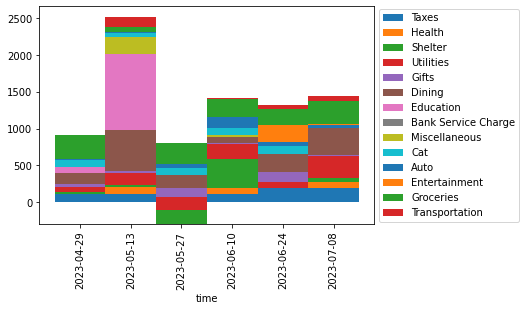

In [26]:
by_cat.plot(stack=True, yerr=False, histtype='fill')
plt.xticks(**xticks_kw)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()